In [1]:
import pandas as pd
import numpy  as np 

import matplotlib.pyplot as plt
import statistics as stat

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Setting seed

SEED = 101
np.random.seed(SEED)

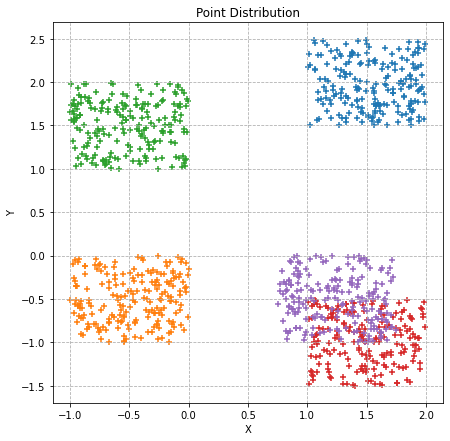

In [4]:
# Toy Dataset creation

## Creating a toy dataset

rand_values = np.random.rand(1000)

cluster_1 = np.array(list(zip( 1  + np.random.rand(200), 1.5 + np.random.rand(200))))
cluster_2 = np.array(list(zip( -1 + np.random.rand(200),  -1 + np.random.rand(200))))
cluster_3 = np.array(list(zip( -1 + np.random.rand(200),   1 + np.random.rand(200))))
cluster_4 = np.array(list(zip(  1 + np.random.rand(200),-1.5 + np.random.rand(200))))
cluster_5 = np.array(list(zip(.75 + np.random.rand(200),  -1 + np.random.rand(200))))

clusters = [cluster_1, cluster_2, cluster_3, cluster_4, cluster_5]

## Plotting the toy dataset

fig = plt.figure(figsize=(7, 7))
for cluster in clusters:
    plt.scatter(cluster[:,0], cluster[:,1], marker='+')
plt.grid(ls='--')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Point Distribution');

## Creating the toy dataframe

toy_df = pd.DataFrame()
for cluster_id, cluster in enumerate(clusters):
    sub_df = pd.DataFrame(cluster, columns=['x', 'y'])
    sub_df['cluster_id'] = cluster_id + 1
    toy_df = pd.concat([toy_df, sub_df])

In [5]:
# Decision Tree Algorithm

## Creating question data structure to perform validity checks
class CreateQuestion:
    def __init__(self, column, value):
        self.column = column
        self.value = value
        
    def check(self, data):
        value = data[self.column]
        return value >= self.value

## Creating leaf node data structure
class Leaf:
    def __init__(self, row):
        self.predictions = class_counts(row)

## Creating decision node data structure   
class DecisionNode:
    def __init__(self, question, true_branch, false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch
    
## Creating partition mechanism
def partition(rows, question):
    true_rows = []
    false_rows = []
    
    for row in rows:
        if question.check(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
    
    return true_rows, false_rows

## Helper function to calculate gini impurity
def gini_impurity(rows):
    counts = class_counts(rows)
    impurity = 1
    for label in counts:
        label_prob = counts[label] / float(len(rows))
        impurity -= label_prob ** 2
    return impurity

## Getting class frequency in data subset
def class_counts(rows):
    counts = {}
    for row in rows:
        label = row[-1]
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

## Helper function to calculate information gain
def information_gain(left, right, current_uncertainty):
    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty \
           - (p * gini_impurity(left)) \
           - ((1 - p) * gini_impurity(right))

## Best split finding mechanism
def find_best_split(rows):
    best_gain = 0
    best_question = None
    current_uncertainty = gini_impurity(rows)
    n_features = len(rows[0]) - 1
    
    for col in range(n_features):
        values = set([row[col] for row in rows]) 
        
        for val in values:
            question = CreateQuestion(col, val)
            true_rows, false_rows = partition(rows, question)
            
            if len(true_rows) == 0 or len(false_rows) == 0:
                continue
            
            gain = information_gain(true_rows,
                                    false_rows,
                                    current_uncertainty)
            
            if gain > best_gain:
                best_gain, best_question = gain, question
    
    return best_gain, best_question

## Recursive function to create entire decision tree
def build_tree(data):
    gain, question = find_best_split(data)
    
    if gain == 0:
        return Leaf(data)
    
    true_rows, false_rows = partition(data, question)
    true_branch  = build_tree(true_rows)
    false_branch = build_tree(false_rows)
    
    return DecisionNode(question, true_branch, false_branch)

## Helper function to classify each decision tree node
def classify(row, node):
    if isinstance(node, Leaf):
        return node.predictions
    
    if node.question.check(row):
        return classify(row, node.true_branch)
    else:
        return classify(row, node.false_branch)

## Producing required predictions    
def dt_predict(X_train, y_train, X_test):
    
    data = pd.concat([X_train, y_train], axis=1).values
    dt_tree = build_tree(data)
    
    predictions = [int(list(classify(x_row, dt_tree).keys())[0]) for x_row in X_test.values]
    return np.array(predictions)

In [6]:
# Train Test Split

X = toy_df.drop(['cluster_id'], axis=1)
y = toy_df['cluster_id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

In [7]:
# Coding the confusion matrix function

import seaborn as sns

def plot_confusion_matrix(y_train, y_test, y_predicted):
    labels = list(np.unique(y_train))
    cm = confusion_matrix(y_test, y_predicted, labels=labels)
    ax = sns.heatmap(cm, annot=True, annot_kws={"size": 16})
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels, rotation=0)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

In [8]:
%%time

# Our Decision Tree Algorithm

m_dt_y_predicted = dt_predict(X_train, y_train, X_test)
m_dt_score = accuracy_score(y_test, m_dt_y_predicted)
print(f"Our Decision Tree Test Set Accuracy Score: {m_dt_score:.3f}")
print(f"Training Data Count: {len(X_train)}, %Training Data: {100 * len(X_train)/len(X):.2f}")
print(f"Test Data Count: {len(X_test)}, %Test Data: {100 * len(X_test)/len(X):.2f}")

Our Decision Tree Test Set Accuracy Score: 0.912
Training Data Count: 750, %Training Data: 75.00
Test Data Count: 250, %Test Data: 25.00
CPU times: user 1.59 s, sys: 0 ns, total: 1.59 s
Wall time: 1.59 s


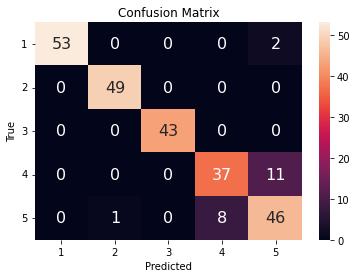

In [9]:
plot_confusion_matrix(y_train, y_test, m_dt_y_predicted)

Text(0.5, 0, 'X')

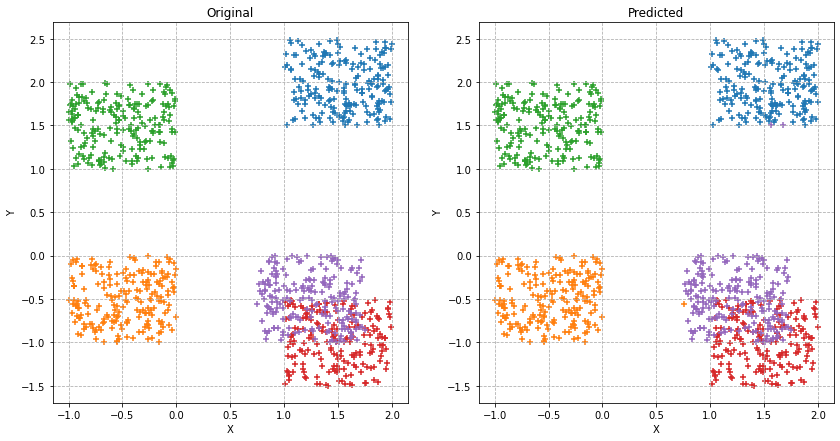

In [10]:
# Plotting Original vs Predicted for m_dt

m_dt_y_train_predicted = dt_predict(X_train, y_train, X_train)

train_df = X_train
train_df['cluster_id'] = m_dt_y_train_predicted

test_df = X_test
test_df['cluster_id']  = m_dt_y_predicted

main_df = pd.concat([X_train, X_test])

fig, axs = plt.subplots(1, 2, figsize=(14, 7))

for _, data in toy_df.groupby('cluster_id'):
    axs[0].scatter(data['x'], data['y'], marker='+')
axs[0].set_title("Original")
axs[0].grid(ls='--')
axs[0].set_ylabel('Y')
axs[0].set_xlabel('X')

for _, data in main_df.groupby('cluster_id'):
    axs[1].scatter(data['x'], data['y'], marker='+')
axs[1].set_title("Predicted")
axs[1].grid(ls='--')
axs[1].set_ylabel('Y')
axs[1].set_xlabel('X')

In [11]:
%%time

# Sci-Kit Learn's Decision Tree Algorithm

dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
sklearn_y_predicted = dt_clf.predict(X_test)
sklearn_y_predicted_score = accuracy_score(y_test, sklearn_y_predicted)
print(f"Sklearn's Decision Tree Test Set Accuracy Score: {sklearn_y_predicted_score:.3f}")
print(f"Training Data Count: {len(X_train)}, %Training Data: {100 * len(X_train)/len(X):.2f}")
print(f"Test Data Count: {len(X_test)}, %Test Data: {100 * len(X_test)/len(X):.2f}")

Sklearn's Decision Tree Test Set Accuracy Score: 0.920
Training Data Count: 750, %Training Data: 75.00
Test Data Count: 250, %Test Data: 25.00
CPU times: user 4.3 ms, sys: 85 µs, total: 4.38 ms
Wall time: 3.58 ms


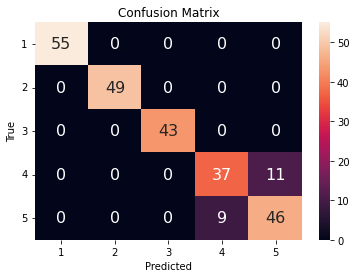

In [12]:
plot_confusion_matrix(y_train, y_test, sklearn_y_predicted)

In [13]:
# Loading Iris dataset

In [14]:
from sklearn.datasets import load_iris

irisData = load_iris()
 
X = pd.DataFrame(irisData.data)
y = pd.DataFrame(irisData.target)
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

In [15]:
%%time

# Our Decision Tree Algorithm

m_dt_y_predicted = dt_predict(X_train, y_train, X_test)
m_dt_score = accuracy_score(y_test, m_dt_y_predicted)
print(f"Our Decision Tree Test Set Accuracy Score: {m_dt_score:.3f}")
print(f"Training Data Count: {len(X_train)}, %Training Data: {100 * len(X_train)/len(X):.2f}")
print(f"Test Data Count: {len(X_test)}, %Test Data: {100 * len(X_test)/len(X):.2f}")

Our Decision Tree Test Set Accuracy Score: 0.974
Training Data Count: 112, %Training Data: 74.67
Test Data Count: 38, %Test Data: 25.33
CPU times: user 28.6 ms, sys: 0 ns, total: 28.6 ms
Wall time: 28 ms


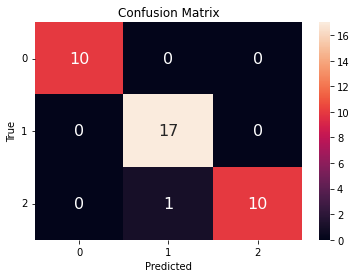

In [16]:
plot_confusion_matrix(y_train, y_test, m_dt_y_predicted)

In [17]:
%%time

# Sci-Kit Learn's Decision Tree Algorithm

dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
sklearn_y_predicted = dt_clf.predict(X_test)
sklearn_y_predicted_score = accuracy_score(y_test, sklearn_y_predicted)
print(f"Sklearn's Decision Tree Test Set Accuracy Score: {sklearn_y_predicted_score:.3f}")
print(f"Training Data Count: {len(X_train)}, %Training Data: {100 * len(X_train)/len(X):.2f}")
print(f"Test Data Count: {len(X_test)}, %Test Data: {100 * len(X_test)/len(X):.2f}")

Sklearn's Decision Tree Test Set Accuracy Score: 0.974
Training Data Count: 112, %Training Data: 74.67
Test Data Count: 38, %Test Data: 25.33
CPU times: user 4.45 ms, sys: 140 µs, total: 4.59 ms
Wall time: 3.93 ms


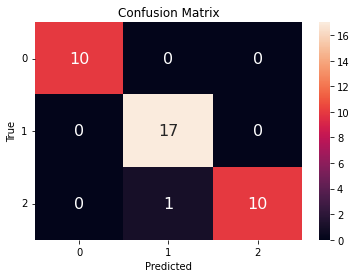

In [18]:
plot_confusion_matrix(y_train, y_test, sklearn_y_predicted)

In [19]:
# Loading Car Dataset

In [20]:
carData = pd.read_csv('./car.data', encoding='utf-8', header=None)

carData.columns = ['buying', 'maintainence', 'doors', 'persons', 'lug_boot', 'safety', 'class']
carData = carData.replace({"class": {"unacc": 4, "acc": 3,'good': 2,'vgood':1}})

X = pd.get_dummies(carData.drop('class', axis=1))
y = carData[['class']]
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=SEED)

In [21]:
%%time

# Our Decision Tree Algorithm

m_dt_y_predicted = dt_predict(X_train, y_train, X_test)
m_dt_score = accuracy_score(y_test, m_dt_y_predicted)
print(f"Our Decision Tree Test Set Accuracy Score: {m_dt_score:.3f}")
print(f"Training Data Count: {len(X_train)}, %Training Data: {100 * len(X_train)/len(X):.2f}")
print(f"Test Data Count: {len(X_test)}, %Test Data: {100 * len(X_test)/len(X):.2f}")

Our Decision Tree Test Set Accuracy Score: 0.954
Training Data Count: 1296, %Training Data: 75.00
Test Data Count: 432, %Test Data: 25.00
CPU times: user 158 ms, sys: 396 µs, total: 158 ms
Wall time: 157 ms


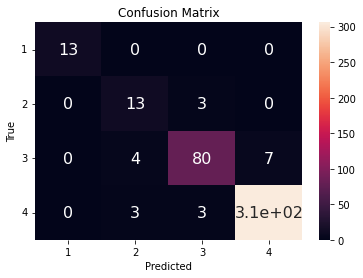

In [22]:
plot_confusion_matrix(y_train, y_test, m_dt_y_predicted)

In [23]:
%%time

# Sci-Kit Learn's Decision Tree Algorithm

dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)
sklearn_y_predicted = dt_clf.predict(X_test)
sklearn_y_predicted_score = accuracy_score(y_test, sklearn_y_predicted)
print(f"Sklearn's Decision Tree Test Set Accuracy Score: {sklearn_y_predicted_score:.3f}")
print(f"Training Data Count: {len(X_train)}, %Training Data: {100 * len(X_train)/len(X):.2f}")
print(f"Test Data Count: {len(X_test)}, %Test Data: {100 * len(X_test)/len(X):.2f}")

Sklearn's Decision Tree Test Set Accuracy Score: 0.947
Training Data Count: 1296, %Training Data: 75.00
Test Data Count: 432, %Test Data: 25.00
CPU times: user 6.25 ms, sys: 0 ns, total: 6.25 ms
Wall time: 5.27 ms


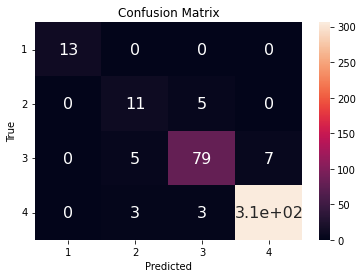

In [24]:
plot_confusion_matrix(y_train, y_test, sklearn_y_predicted)